# Introduction

The objective of this project is to compare various classication and clustering algorithms,
when applied to the *Online Shoppers Purchasing Intention Dataset Data Set*,
which can be found at the UCI Machine Learning Repository at the following link:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset.

The dataset contains information about the visitors of a shopping website, including metrics taken from Google Analytics.
The objective is to predict wheter a certain visitor will generate revenue or not: this could allow to offer certain
content only to those who intend to purchase and not to the other users.

The dataset was formed so that each session would belong to a different user in a 1-year period to avoid
any tendency to a specific campaign, special day, user profile, or period.


# Initial Setup

## Package Installation

The project will need the following packages:

In [25]:
%pip install - U scikit-learn tensorflow keras-tuner pandas graphviz matplotlib xgboost imbalanced-learn autosklearn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Imports

We need to import a few common module, initialize random seeds,
ensure MatplotLib plots figures inline and we also prepare a function to save the figures.
We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
import tensorflow
import numpy as np
import sklearn
import sys

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# Initialize random seeds
np.random.seed(42)
tensorflow.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Where to save the figures
ROOT_DIR = "."
PROJECT_DIR = "mldm_luca_cotti"
IMAGES_PATH = os.path.join(ROOT_DIR, "images", PROJECT_DIR)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """ Saves a figure """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


2022-08-11 16:43:40.978131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 16:43:40.978163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download Dataset

Since the dataset is provided as a `csv`, we can use the `read_csv` function of `pandas` to import it directly from the URL.

In [3]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
dataset = pd.read_csv(DATASET_URL)


### Structure of the dataset

We can use the `info` method to print a concise summary of the dataset.

In [4]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

The dataset contains a total of `12330` entries, with `18` features.
Some features are numeric, others are categorical.

`Administrative`, `Administrative Duration`, `Informational`, `Informational Duration`, `Product Related` and `Product Related Duration` represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories.

The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another.

The `Bounce Rate`, `Exit Rate` and `Page Value` features represent the metrics measured by Google Analytics for each page in the e-commerce site.

The value of `Bounce Rate` feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.

The value of `Exit Rate` feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.

The `Page Value` feature represents the average value for a web page that a user visited before completing an e-commerce transaction.

The `Special Day` feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction.
The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8.

`Revenue` represents the class of the instance: a `True` value means the user generated revenue, and a `False` value means the user did not generate revenue.

The dataset also includes operating system, browser, region, traffic type, visitor type as returning or new visitor, a Boolean value indicating whether the date of the visit is weekend, and month of the year.

We can get a glimpse of the data by using the `head` method.

In [5]:
dataset.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


It's also important to check if the number of instances in each class is balanced:

In [6]:
dataset["Revenue"].value_counts(normalize=True)


False    0.845255
True     0.154745
Name: Revenue, dtype: float64

The `84.5%` of instances are negative, while the the `15.5%` are positive.
This means that the dataset is imbalanced.

There are a few different ways to handle imbalanced datasets,
such as *undersampling* the majority class, or *oversampling* the minority one.
We could also use *SMOTE* to generate synthetic samples from the minority class.

In this project, we will not make use of such techniques directly, but we will
tune the algorithms to account for the imbalance as much as possible,
and we will also use algorithms created specifically for imbalanced datasets.
Most of these algorithms do use one (or more) of the methods mentioned above.

Rather than the basic *accuracy* metric, we will use *balanced accuracy*, which is suited for imbalanced data.
*Balanced accuracy* is defined as the arithmetic mean of *accuracy* and *recall*:

$$
\text{Balanced Accuracy} = \frac{sensitivity + specificity}{2}
$$

We could also use the *F1 score* metric, which is the harmonic mean of *precision* and *recall*:

$$
\text{F1 Score} = 2 * \frac{precision * sensitivity}{precision + sensitivity}
$$

Where *sensitivity* is the proportion of actual positives that are correctly identified as such,
*specificity* is the proportion of actual negatives that are correctly identified,
and *precision* quantifies the number of correct positive predictions made out of positive predictions made by the model.

$$
\text{Sensitivity} = \frac{TP}{TP + FN}
\hspace{6 mm}
\text{Specificity} = \frac{TN}{TN + FP}
\hspace{6 mm}
\text{Precision} = \frac{TP}{TP + FP}
$$

*F1 score* however doesn’t care about how many true negatives are being classified.
For the purposes of this project positives are as import as negatives, so *balanced accuracy* is a better metric.

# Data Cleaning and Feature Engineering

## Column names

The column naming convention appears to be inconsistent.
We can begin the data cleaning process by converting the column names to *snake_case*.

In [7]:
def to_snake_case(str):
    res = [str[0].lower()]
    for i, c in enumerate(str[1:]):
        if c in ('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
            if str[i] != "_":
                res.append('_')
            res.append(c.lower())
        else:
            res.append(c)

    return ''.join(res)


In [ ]:
dataset.columns = dataset.columns.map(lambda c: to_snake_case(c))

## Column Types

There are a few columns that represent categorical data, and two boolean columns that could cause problems. We can convert such columns to more convenient data types.

### Convert categorical data

The dataset has two categorical features with string values: `Month` and `VisitorType`.
We can observe the possible values of these features.

In [9]:
print(dataset["month"].unique())
print(dataset["visitor_type"].unique())


['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
['Returning_Visitor' 'New_Visitor' 'Other']


These features can be converted into integers using `sklearn.preprocessing.LabelEncoder()`, which replaces the category string values with increasing integers values.

The problem with this method is that the learning algorithms could interpret the integer values as having an order/hierarchy between them.

This is fine for the `Month` column, where the various months will be encoded with integers between 0 and 11: these integers do have a meaningful order, so label encoding is correct.

However for `VisitorType` the integer values that the feature could have to represent the string values have no order/hierarchy.
For this reason, a more appropriate conversion for this feature would be to use one-hot encoding.
In this strategy, each possible category value is converted into a new column
and assigned a 1 or 0 value depending on the value in the original column.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataset["month"] = le.fit_transform(dataset["month"])

dum_df = pd.get_dummies(dataset["visitor_type"], prefix="visitor_type")
dum_df.columns = dum_df.columns.map(lambda c: to_snake_case(c))

dataset = dataset.join(dum_df).drop("visitor_type", axis=1)


### Convert boolean values to integer

The `weekend` and `revenue` columns have boolean values, which should automatically be converted to `0` and `1` by Python, but since some of the algorithms may have some parts implemented in C/C++, we might run into some problems.

To avoid this, we can convert such columns to integer values.

In [11]:
dataset["weekend"] = dataset["weekend"].astype(int)
dataset["revenue"] = dataset["revenue"].astype(int)


## Missing values

We can check if the dataset contains NA values, and if it does we can delete such rows as they might ruin the learning process.

In [12]:
dataset.isna().any()


administrative                    False
administrative_duration           False
informational                     False
informational_duration            False
product_related                   False
product_related_duration          False
bounce_rates                      False
exit_rates                        False
page_values                       False
special_day                       False
month                             False
operating_systems                 False
browser                           False
region                            False
traffic_type                      False
weekend                           False
revenue                           False
visitor_type_new_visitor          False
visitor_type_other                False
visitor_type_returning_visitor    False
dtype: bool

The dataset does not contain any NA value, so no rows needs to be eliminated.

## Correlated Columns

To increase the speed of the learning process and reduce bias a possibility is to remove highly correlated columns from the dataset. 

However, while developing this project, we discovered *Recursive Feature Elimination*, which provides a more effective way of removing unnecessary features.

We are leaving this section here anyway for compleness.

In [13]:
def get_correlated_cols(ds: pd.DataFrame, corr_threshold: float):
    # Compute correlation matrix using pearson method (linear correlation)
    corr = ds.corr(method="pearson")
    # Find collinear columns
    corr_cols = corr[corr > corr_threshold].dropna(
        thresh=2).dropna(axis="columns")
    return corr_cols


In [14]:
get_correlated_cols(dataset, 0.90)


,bounce_rates,exit_rates
bounce_rates,1.000000,0.913004
exit_rates,0.913004,1.000000


`bounce_rates` and `exit_rates` are highly correlated. We can remove one of the two columns.

In [ ]:
# dataset.drop("exit_rates", axis=1, inplace=True)


## Duplicate Rows

It's good practice to identify and remove duplicate rows in the dataset, because they could result in misleading performance when evaluating ML algorithms: duplicate rows could appear in both train and test datasets.

In [15]:
dups = dataset.duplicated()
print(dups.any())


True


There are duplicates in the dataset. They can be removed using pandas `drop_duplicates`.

In [16]:
dataset.drop_duplicates(inplace=True)


## Feature scaling

In order to weight the features equally, feature scaling is important.
Here we use the `MinMaxScaler`, which scales all values to the [0,1] interval.

In [17]:
from pandas.core.common import random_state
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
dataset = pd.DataFrame(mms.fit_transform(dataset), columns=dataset.columns)


## Create test and training sets

We will use the 70% of the total instances for training, and the remaining 30% for testing.

The `stratify` option of `train_test_split` ensures that relative class frequencies are approximately preserved in the training and test sets.

In [18]:
from sklearn.model_selection import train_test_split

X = dataset.drop("revenue", axis=1)
y = dataset["revenue"].copy()

X_train, X_test, y_train,  y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)


## Recursive Feature Elimination

*Recursive Feature Elimination* (RFE) is a feature selection algorithms.
Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset. Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

RFE in particular searches for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting a given machine learning algorithm, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

Choosing the optimal number of features to keep is not trivial: 
`scikit-learn` provides the `RFECV` class, which performs cross-validation evaluation of different numbers of features and automatically selects the features that resulted in the best mean score.

Since we know that the dataset is imbalanced, we use a random forest classifier to compute the weights associated with the features (the features with the lowest weights are those that will be removed), along with the `balanced_accuracy` to measure performance during the cross-validation. 

In [19]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=42),
    min_features_to_select=1,  # Eliminate at least one feature
    scoring="balanced_accuracy"
)

rfecv.fit(X_train, y_train)


RFECV(estimator=RandomForestClassifier(random_state=42),
      scoring='balanced_accuracy')

In [20]:
print("Eliminated %d features, from %d features to %d features" % (
    len(X.columns) - rfecv.n_features_,
    len(X.columns),
    rfecv.n_features_
)
)

columns_to_keep = X.columns[rfecv.support_]

X = X[columns_to_keep]
X_train = X_train[columns_to_keep]
X_test = X_test[columns_to_keep]


Eliminated 12 features, from 19 to 7


## Utility functions

In [22]:
from sklearn.metrics import balanced_accuracy_score


def evaluate(clf):
    """
    Evaluates a classifier on the test set.
    """
    y_pred = clf.predict(X_test)
    print("Accuracy (on test set): ", balanced_accuracy_score(y_test, y_pred))


def evaluate_grid(grid_clf):
    """
    Evaluates a grid search on the test set.
    """
    print("Best parameters: ", grid_clf.best_params_)
    print("Accuracy of best (means of cross-validated scores on train set): ",
          grid_clf.best_score_)
    print("Accuracy of best (on test set): ",
          balanced_accuracy_score(y_test, grid_clf.predict(X_test)))


# Basic Classifiers

## Decision Tree

We expect decision trees to behave well for this problem, because they are particularly suited for imbalanced classifications.

We will begin with a baseline decision tree, that we will try to improve upon by tuning the hyperparameters.

In [23]:
from sklearn.tree import DecisionTreeClassifier

# class_weight=balanced adjusts weights inversely proportional to class frequencies
tree_clf = DecisionTreeClassifier(
    max_depth=2, random_state=42, class_weight="balanced")
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

In [24]:
evaluate(tree_clf)


Accuracy (on test set):  0.8419354108674497


We can also visualize the decision tree:

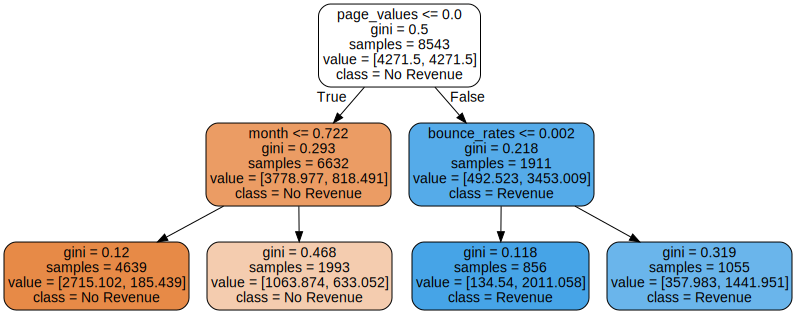

In [26]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=os.path.join(IMAGES_PATH, "tree.dot"),
    feature_names=X.columns,
    class_names=["No Revenue", "Revenue"],
    filled=True,
    rounded=True,
)

Source.from_file(os.path.join(IMAGES_PATH, "tree.dot"))


To check for overfitting, we can plot the accuracy on the training and test sets.
Here we also evaluate how the decision trees behaves when using different criteria.

In [27]:
def evaluate_decision_tree(values, criterion="gini"):
    train_scores, test_scores = list(), list()

    for i in values:
        # configure the model
        model = DecisionTreeClassifier(
            max_depth=i, criterion=criterion, random_state=42)
        # fit model on the training dataset
        model.fit(X_train, y_train)
        # evaluate on the train dataset
        train_yhat = model.predict(X_train)
        train_acc = balanced_accuracy_score(y_train, train_yhat)
        train_scores.append(train_acc)

        # evaluate on the test dataset
        test_yhat = model.predict(X_test)
        test_acc = balanced_accuracy_score(y_test, test_yhat)
        test_scores.append(test_acc)
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    # plot of train and test scores vs tree depth
    plt.plot(values, train_scores, '-o', label='Train')
    plt.plot(values, test_scores, '-o', label='Test')
    plt.legend()
    plt.show()


>5, train: 0.767, test: 0.748
>6, train: 0.804, test: 0.770
>7, train: 0.814, test: 0.769
>8, train: 0.819, test: 0.746
>9, train: 0.847, test: 0.741
>10, train: 0.870, test: 0.739
>11, train: 0.886, test: 0.749
>12, train: 0.901, test: 0.738
>13, train: 0.922, test: 0.730
>14, train: 0.932, test: 0.735
>15, train: 0.950, test: 0.742
>16, train: 0.951, test: 0.729
>17, train: 0.966, test: 0.749
>18, train: 0.973, test: 0.737
>19, train: 0.972, test: 0.733
>20, train: 0.978, test: 0.734
>21, train: 0.978, test: 0.739
>22, train: 0.981, test: 0.732
>23, train: 0.985, test: 0.729
>24, train: 0.986, test: 0.736
>25, train: 0.987, test: 0.745
>26, train: 0.989, test: 0.742
>27, train: 0.992, test: 0.736
>28, train: 0.996, test: 0.735
>29, train: 0.998, test: 0.734


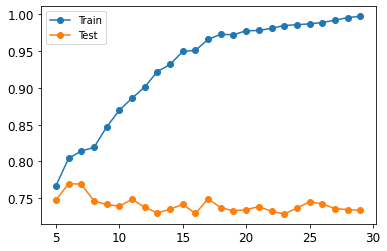

In [28]:
evaluate_decision_tree([i for i in range(5, 30)])


>5, train: 0.752, test: 0.735
>6, train: 0.798, test: 0.774
>7, train: 0.808, test: 0.772
>8, train: 0.797, test: 0.737
>9, train: 0.825, test: 0.745
>10, train: 0.845, test: 0.734
>11, train: 0.864, test: 0.737
>12, train: 0.887, test: 0.738
>13, train: 0.910, test: 0.737
>14, train: 0.927, test: 0.737
>15, train: 0.932, test: 0.738
>16, train: 0.944, test: 0.735
>17, train: 0.951, test: 0.739
>18, train: 0.963, test: 0.738
>19, train: 0.969, test: 0.737
>20, train: 0.974, test: 0.739
>21, train: 0.977, test: 0.739
>22, train: 0.980, test: 0.730
>23, train: 0.988, test: 0.739
>24, train: 0.989, test: 0.737
>25, train: 0.992, test: 0.731
>26, train: 0.993, test: 0.738
>27, train: 0.995, test: 0.735
>28, train: 0.997, test: 0.739
>29, train: 0.997, test: 0.735


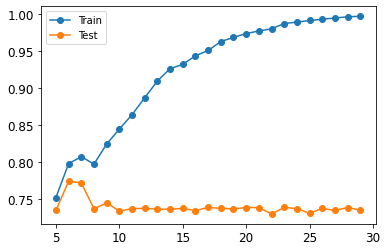

In [29]:
evaluate_decision_tree([i for i in range(5, 30)], criterion="entropy")


For a more comprehensive hyperparameter tuning, `scikit-learn` provides the `GridSearchCV` class, which creates a grid search to find the best possibile hyperparameters for a model (by exhaustively trying all possible combinations of the given parameters), and evaluates each possible model through cross-validation, in order to keep overfitting in check. The model with the highest cross-validated score will be kept as the best one.

We also evaluate the (balanced) accuracy of the best model using the test set.

In [30]:
from sklearn.model_selection import GridSearchCV
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(1, 10)),
    "max_features": [None, "log2", "sqrt"],
}


tree_clf = DecisionTreeClassifier(random_state=42, class_weight="balanced")
grid_tree_clf = GridSearchCV(tree_clf, params, scoring="balanced_accuracy")
grid_tree_clf.fit(X_train, y_train)


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'log2', 'sqrt']},
             scoring='balanced_accuracy')

In [31]:
evaluate_grid(grid_tree_clf)


Best parameters:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': None}
Accuracy of best (means of cross-validated scores on train set):  0.8501342341213902
Accuracy of best (on test set):  0.8477708375766628


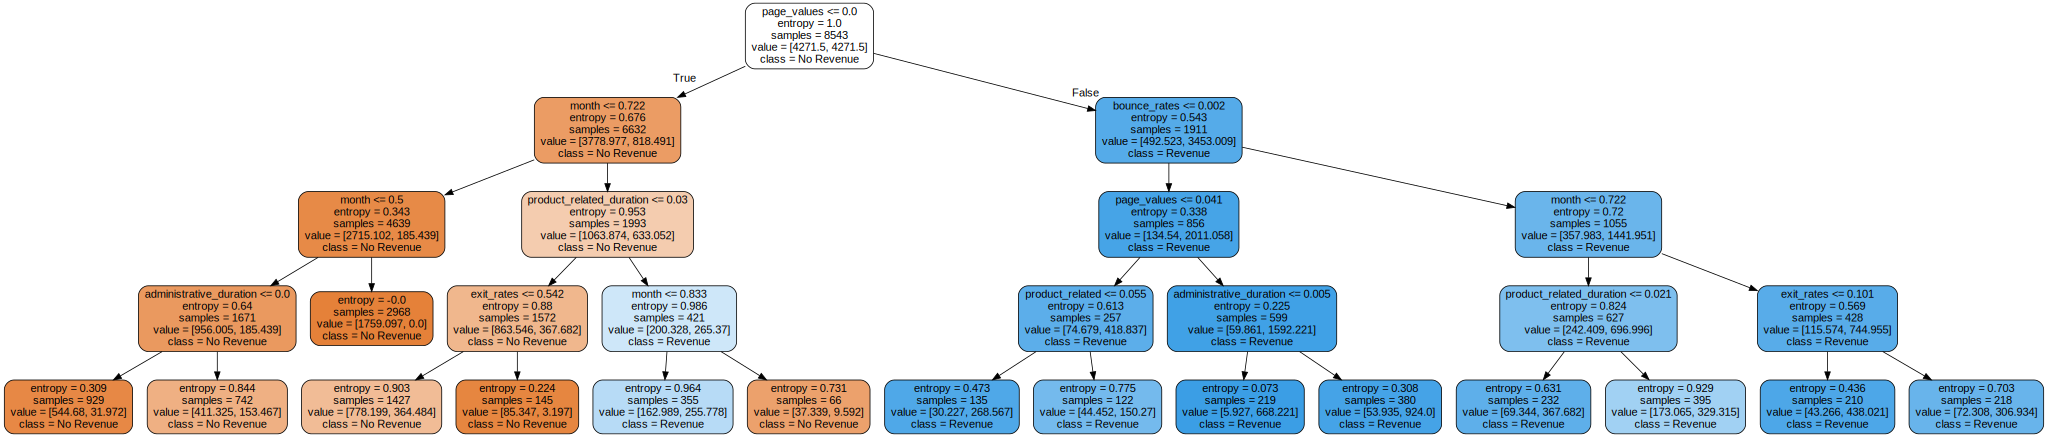

In [33]:
export_graphviz(
    grid_tree_clf.best_estimator_,
    out_file=os.path.join(IMAGES_PATH, "best_tree.dot"),
    feature_names=X.columns,
    class_names=["No Revenue", "Revenue"],
    filled=True,
    rounded=True,
)

Source.from_file(os.path.join(IMAGES_PATH, "best_tree.dot"))


## K-Nearest Neighbor

The *K-Nearest Neighbor* (KNN) algorithm struggles with imbalanced data (at least in its basic form), but at the same it should also perform particularly well for datasets with a lower number of features.
Thanks to RFE, we managed to reduce the number of features to 9, so it is interesting to verify the results of KNN.

We can also verify how the accuracy changes with various distance metrics.

In [76]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors": list(range(1, 10)),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "chebyshev", "minkowski", "manhattan"]
}

knn_clf = KNeighborsClassifier()

grid_knn_clf = GridSearchCV(knn_clf, params, scoring="balanced_accuracy")
grid_knn_clf.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'chebyshev', 'minkowski',
                                    'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [77]:
evaluate_grid(grid_knn_clf)


Best parameters:  {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Accuracy of best (means of cross-validated scores on train set):  0.7290814711036219
Accuracy of best (on test set):  0.7221982709846787


## Logistic Regression

Since logistic regression is especially well-suited for binary problems, we expect this method to give good results.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

log_clf = LogisticRegressionCV(
    random_state=42,
    scoring="balanced_accuracy",
    max_iter=500,
    class_weight="balanced"
)

log_clf.fit(X_train, y_train)


LogisticRegressionCV(class_weight='balanced', max_iter=500, random_state=42,
                     scoring='balanced_accuracy')

In [ ]:
evaluate(log_clf)


Accuracy (on test set):  0.8184607463733677


## SVM

In [ ]:
from sklearn.svm import SVC

params = {
    "C": [1, 10, 50],
    "gamma": ["scale", 1, 0.1, 0.01],
    "kernel": ["linear", "rbf", "poly"],
    "degree": [2, 3, 4]
}

svm_clf = SVC(random_state=42, class_weight="balanced")

grid_svm_clf = GridSearchCV(svm_clf, params, scoring="balanced_accuracy")
grid_svm_clf.fit(X_train, y_train)


GridSearchCV(estimator=SVC(class_weight='balanced', random_state=42),
             param_grid={'C': [1, 10, 50], 'degree': [2, 3, 4],
                         'gamma': ['scale', 1, 0.1, 0.01],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='balanced_accuracy')

In [ ]:
evaluate_grid(grid_svm_clf)


Best parameters:  {'C': 50, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy of best (means of cross-validated scores on train set):  0.8285570898617853
Accuracy of best (on test set):  0.8273004503587027


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

params = {
    "var_smoothing": np.logspace(0, -9, num=300)
}

gnb_clf = GaussianNB()

grid_gnb_clf = GridSearchCV(gnb_clf, params, scoring="balanced_accuracy")
grid_gnb_clf.fit(X_train, y_train)

evaluate_grid(grid_gnb_clf)


Best parameters:  {'var_smoothing': 0.00015040335536380253}
Accuracy of best (means of cross-validated scores on train set):  0.7703546558177674
Accuracy of best (on test set):  0.7605115758028379


# Ensemble Classifiers

## Bagging

The `BaggingClassifier` provided by scikit-learn wouldn't be good for this dataset, because it does not take in account the imbalance in the instances: the resulting classifier would have a bias towards the majority class.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(random_state=42)
bag_clf.fit(X_train, y_train)


BaggingClassifier(random_state=42)

In [ ]:
evaluate(bag_clf)


Accuracy (on test set):  0.745184103921968


The `BalancedBaggingClassifier` included in `imbalanced-learn` is more appropriate because it includes an additional step to balance the training set at fit time using a given sampler. The default sampler works by doing a random undersampling of the majority class.

In [34]:
from imblearn.ensemble import BalancedBaggingClassifier

params = {
    "n_estimators": [100, 200, 500],
    "max_samples": [0.2, 0.5, 1.0],
    "max_features": [0.5, 1.0],
}

grid_bb_clf = GridSearchCV(
    BalancedBaggingClassifier(random_state=42, oob_score=True),
    params,
    scoring="balanced_accuracy"
)

grid_bb_clf.fit(X_train, y_train)


GridSearchCV(estimator=BalancedBaggingClassifier(oob_score=True,
                                                 random_state=42),
             param_grid={'max_features': [0.5, 1.0],
                         'max_samples': [0.2, 0.5, 1.0],
                         'n_estimators': [100, 200, 500]},
             scoring='balanced_accuracy')

In [35]:
evaluate_grid(grid_bb_clf)


Best parameters:  {'max_features': 1.0, 'max_samples': 0.2, 'n_estimators': 200}
Accuracy of best (means of cross-validated scores on train set):  0.8520401962169952
Accuracy of best (on test set):  0.8540498336614841


## Random Forest

For the same reason as basic bagging, we can expect random forests and extra trees to produce unsatisfying results.

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [37]:
evaluate(rf_clf)


Accuracy (on test set):  0.7680081245615227


In [38]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(random_state=42, class_weight="balanced")
et_clf.fit(X_train, y_train)


ExtraTreesClassifier(class_weight='balanced', random_state=42)

In [39]:
evaluate(et_clf)


Accuracy (on test set):  0.7587163645416073


Both method have a relatively low (balanced) accuracy, even if the class weight is set to `balanced`.

`BalancedRandomForest` should provide better results, by undersampling the majority class.

In [40]:
from imblearn.ensemble import BalancedRandomForestClassifier

params = {
    "n_estimators": [200, 300],
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(5, 10)),
    "max_features": ["log2", "sqrt"],
}

grid_brf_clf = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42, oob_score=True),
    params,
    scoring="balanced_accuracy"
)

grid_brf_clf.fit(X_train, y_train)


GridSearchCV(estimator=BalancedRandomForestClassifier(oob_score=True,
                                                      random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [200, 300]},
             scoring='balanced_accuracy')

In [ ]:
evaluate_grid(grid_brf_clf)


Best parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 300}
Accuracy of best (means of cross-validated scores on train set):  0.8554375498184059
Accuracy of best (on test set):  0.8501963247108878


## Random Undersampling with Boosting

`imbalanced-learn` also includes `RUSBoostClassifier`, which does random under-sampling integrated in the learning of AdaBoost.

In [41]:
from imblearn.ensemble import RUSBoostClassifier

params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1],
}

grid_rus_clf = GridSearchCV(
    RUSBoostClassifier(random_state=42),
    params,
    scoring="balanced_accuracy"
)

grid_rus_clf.fit(X_train, y_train)


GridSearchCV(estimator=RUSBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='balanced_accuracy')

In [43]:
evaluate_grid(grid_rus_clf)


Best parameters:  {'learning_rate': 0.1, 'n_estimators': 50}
Accuracy of best (means of cross-validated scores on train set):  0.8451061106531841
Accuracy of best (on test set):  0.8421605902188427


## EasyEnsemble

The final classifier included in `imbalanced-learn` is `EasyEnsemble`, that is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.

In [45]:
from imblearn.ensemble import EasyEnsembleClassifier

params = {
    "n_estimators": [50, 100, 200],
}

grid_ee_clf = GridSearchCV(
    EasyEnsembleClassifier(random_state=42),
    params,
    scoring="balanced_accuracy"
)

grid_ee_clf.fit(X_train, y_train)


GridSearchCV(estimator=EasyEnsembleClassifier(random_state=42),
             param_grid={'n_estimators': [50, 100, 200]},
             scoring='balanced_accuracy')

In [46]:
evaluate_grid(grid_ee_clf)


Best parameters:  {'n_estimators': 200}
Accuracy of best (means of cross-validated scores on train set):  0.8456847750690647
Accuracy of best (on test set):  0.8467597936044537


## XGBoost

In [47]:
from collections import Counter

counter = Counter(y)
estimate = counter[0] / counter[1]
print("Estimate: %.3f" % estimate)


Estimate: 5.397


In [48]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42, scale_pos_weight=estimate,
                        objective="binary:logistic", verbosity=0)

params = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.5, 0.8]
}

grid_xgb_clf = GridSearchCV(xgb_clf, params, scoring="balanced_accuracy")
grid_xgb_clf.fit(X_train, y_train)


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.8],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1]},
             scoring='balanced_accuracy')

In [ ]:
evaluate_grid(grid_xgb_clf)


## Voting

In [70]:
from sklearn.ensemble import VotingClassifier


def get_models():
    models = list()
    models.append(("bb",  grid_bb_clf.best_estimator_))
    models.append(("brf",  grid_brf_clf.best_estimator_))
    models.append(("rus",  grid_rus_clf.best_estimator_))
    models.append(("ee",  grid_ee_clf.best_estimator_))
    models.append(("xgb",  grid_xgb_clf.best_estimator_))
    return models


voting_clf = VotingClassifier(estimators=get_models(), voting="hard")
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('bb',
                              BalancedBaggingClassifier(max_samples=0.2,
                                                        n_estimators=200,
                                                        oob_score=True,
                                                        random_state=42)),
                             ('brf',
                              BalancedRandomForestClassifier(max_depth=8,
                                                             max_features='log2',
                                                             n_estimators=300,
                                                             oob_score=True,
                                                             random_state=42)),
                             ('rus',
                              RUSBoostClassifier(learning_rate=0.1,
                                                 random_state=42)),
                             ('ee',
                              EasyEnsembleClassifier(n_estimators...
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.01, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=5,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=50, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=42,
                                            reg_alpha=0, reg_lambda=1, ...))])

In [71]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring="balanced_accuracy", cv=cv, n_jobs=-1, error_score="raise")
	return scores

eval_list=get_models()
eval_list.append(("voting_hard", voting_clf))

results, names = list(), list()
for name, model in eval_list:
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)

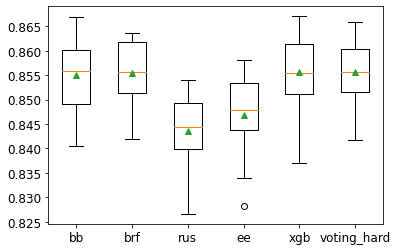

In [73]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()


# Neural Network

To easily create a basic Neural Network, `keras` can be used.
To test the effectiveness of a Neural Network to this particular problem, we create a baseline neural network with one hidden layer of 10 nodes.

In [ ]:
from tensorflow import keras

model = keras.models.Sequential([
    # The number of inputs has to be equal
    # to the number of features of the dataset
    keras.Input(shape=X_train.shape[1]),

    # Hidden layer
    keras.layers.Dense(10, activation="relu"),

    # One output node, which is a sigmoid:
    # the value will be continuous between 0 and 1.
    # To cast it to binary, we will need to assign
    # value 1 if greater than 0.5, or else 0.
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


Now that the neural network has been defined, it needs to be compiled.
As suggested in https://carpentries-incubator.github.io/deep-learning-intro/02-keras/index.html, it is possibile to use a precompiled model rather
than compiling a new one. Since the model is simple and requires very little
computation time, we will build it from scratch.

The same document suggests `Adam` as a sensible optimizer for the network. 

Since the output needs to be binary, `BinaryCrossentropy()` is an appropriate loss function.

In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


The compiled model can be now trained: as a test, we will run it with 100 epochs. This number is, once again, arbitrary and will most likely need to be tweaked.

The `y_train` list cannot however be used directly, because the neural network
cannot directly output a categorical value: to overcome this, the `y_train`
list is transformed using Hot-Encoding.

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=1,
    validation_data=(X_test, y_test))


Epoch 1/20
267/267 [==============================] - 1s 3ms/step - loss: 0.3009 - accuracy: 0.8812 - val_loss: 0.3049 - val_accuracy: 0.8853
Epoch 2/20
267/267 [==============================] - 1s 3ms/step - loss: 0.3005 - accuracy: 0.8818 - val_loss: 0.3048 - val_accuracy: 0.8837
Epoch 3/20
267/267 [==============================] - 1s 2ms/step - loss: 0.3001 - accuracy: 0.8822 - val_loss: 0.3048 - val_accuracy: 0.8829
Epoch 4/20
267/267 [==============================] - 1s 2ms/step - loss: 0.2998 - accuracy: 0.8827 - val_loss: 0.3040 - val_accuracy: 0.8859
Epoch 5/20
267/267 [==============================] - 1s 2ms/step - loss: 0.2995 - accuracy: 0.8822 - val_loss: 0.3035 - val_accuracy: 0.8839
Epoch 6/20
267/267 [==============================] - 1s 2ms/step - loss: 0.2990 - accuracy: 0.8827 - val_loss: 0.3029 - val_accuracy: 0.8850
Epoch 7/20
267/267 [==============================] - 1s 2ms/step - loss: 0.2987 - accuracy: 0.8827 - val_loss: 0.3025 - val_accuracy: 0.8856
Epoch 

To evaluate the model we can begin by looking at evolution of the value of the loss
function.

### Plot Results

In [ ]:
def plot_results(history):
    """
    Plots the results of the model training

    :param history: object returned by the train function that contains all train infos
    """
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    # Plot line charts for both Validation and Training Loss
    line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
    line2 = plt.plot(epochs, loss_values, label='Training Loss')
    plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    history_dict = history.history

    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(loss_values) + 1)

    line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
    line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
    plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
    plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


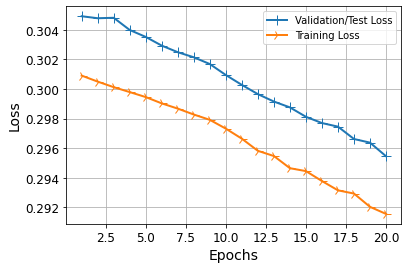

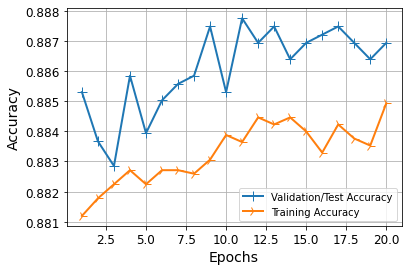

In [ ]:
plot_results(history)


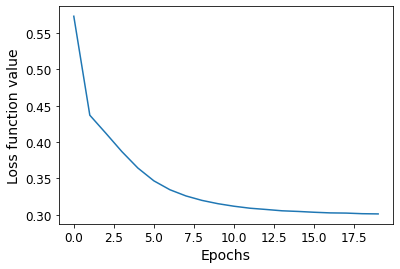

In [ ]:
plt.plot(history.epoch, history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss function value")
plt.show()


The graph shows that the loss function, at 20 epochs, is still decreasing:
a higher number of epochs, with the same model configuration, should lower
the loss function value, and improve the quality of the predictions.
A too high number of epochs however may lead to overfitting.

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: ", accuracy)


115/115 [==============================] - 0s 1ms/step - loss: 0.3053 - accuracy: 0.8839
Accuracy:  0.8839432001113892


Even with arbitrary parameters, the resulting accuracy is very high.
Parameter tuning may allow to further improve accuracy.

We can also plot a heatmap of the conusion matrix of the model

[[3018   72]
 [ 354  218]]


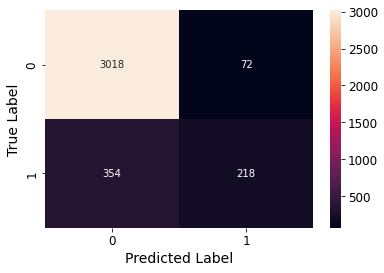

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test).flatten()
y_pred = pd.Series(y_pred).map(lambda y: 1 if y >= 0.5 else 0)
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(matrix)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(matrix)

# Set the names of the x and y axis, this helps with the readability of the heatmap.
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt="d")


NOTE ON TOO MANY NEGATIVE EXAMPLES

## Hyperparameter Tuning

To tune the hyperparameters of a keras neural network, we can use the `keras-tuner` package.

In [ ]:
from keras import layers
import keras_tuner


def build_model(hp):
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(layers.Flatten())

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                # Choose an optimal value between 32-512
                units=hp.Int(f"units_{i}", min_value=32,
                             max_value=512, step=32),
                activation="relu"
            )
        )

    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(1, activation="sigmoid"))

    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4,
                             max_value=1e-2, sampling="log")

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])

    return model


In [ ]:
from keras_tuner import HyperParameters
build_model(HyperParameters())


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)


In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2)
tuner.search(X_train_nn, y_train_nn, epochs=20,
             validation_data=(X_val_nn, y_val_nn))


Trial 3 Complete [00h 00m 33s]
val_accuracy: 0.8961381018161774

Best val_accuracy So Far: 0.8961381018161774
Total elapsed time: 00h 02m 22s


In [ ]:
tuner.results_summary()


Results summary
Results in my_dir/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 1
units_0: 64
dropout: True
lr: 0.004236185538505342
units_1: 96
Score: 0.8961381018161774
Trial summary
Hyperparameters:
num_layers: 2
units_0: 320
dropout: False
lr: 0.001926479219429071
units_1: 32
Score: 0.8940901160240173
Trial summary
Hyperparameters:
num_layers: 2
units_0: 224
dropout: True
lr: 0.0003954434199091812
units_1: 416
Score: 0.8917495608329773


In [ ]:
# Get the top model.
best_model = tuner.get_best_models(num_models=1)[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=X.shape)
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (12205, 18)               0         
                                                                 
 dense (Dense)               (12205, 64)               1216      
                                                                 
 dropout (Dropout)           (12205, 64)               0         
                                                                 
 dense_1 (Dense)             (12205, 1)                65        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_, accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: ", accuracy)


115/115 [==============================] - 0s 1ms/step - loss: 0.2583 - accuracy: 0.8951
Accuracy:  0.8951392769813538


[[2979  111]
 [ 273  299]]


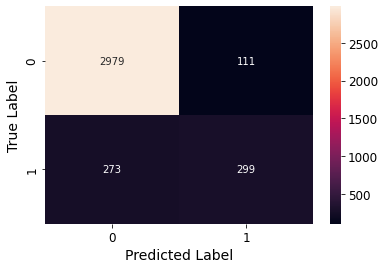

In [ ]:
y_pred = best_model.predict(X_test).flatten()
y_pred = pd.Series(y_pred).map(lambda y: 1 if y >= 0.5 else 0)
matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(matrix)

# Convert to a pandas dataframe
confusion_df = pd.DataFrame(matrix)

# Set the names of the x and y axis, this helps with the readability of the heatmap.
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

sns.heatmap(confusion_df, annot=True, fmt="d")


# Autosklearn

In [ ]:
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

cls = AutoSklearn2Classifier()
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)
print("Accuracy: ", balanced_accuracy_score(y_test, y_pred))


IncorrectPackageVersionError: ignored

In [ ]:
import autosklearn.classification

cls = autosklearn.classification.AutoSklearnClassifier()
cls.fit(X_train, y_train)
predictions = cls.predict(X_test)


Process ForkProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 320, in start_log_server
    receiver.serve_until_stopped()
  File "/usr/local/lib/python3.7/dist-packages/autosklearn/util/logging_.py", line 352, in serve_until_stopped
    self.timeout)
KeyboardInterrupt
